## Multiple linear regression
This code runs multiple linear regression within object-selective epoch defined based on ANOVA result. 

Response-selective neurons were filtered out by nested regression.

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats.mstats import zscore

from scipy.ndimage import gaussian_filter
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

import matplotlib as mpl
import matplotlib.pyplot as plt  

from datetime import date
import time

import random

from joblib import Parallel, delayed

import h5py

In [2]:
# no top and right spines in all plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
mother_path = Path('D:/Multi-modal project/')

### Parameter setting

In [4]:
num_iter = 1000

gauss_sigma = 2

# colors for multimodal, vis-only, aud-only conditions
color = ['tab:purple','tab:blue','tab:red','tab:green']
color2 = ['cyan','magenta','brown']
linestyle = ['-',':']

today = str(date.today())

### Data preparation

In [5]:
save_path = mother_path /'analysis'/'result'/'3.1 Multiple linear regression'/today
cell_path = mother_path/'analysis'/'result'/'zFR export'/'13-Jun-2023'
data_path = mother_path /'analysis'/'result'/'3. ANOVA'

cell_list = os.listdir(cell_path)

# load hdf5 files containing ANOVA results
f = h5py.File(data_path/'2023-07-10'/'2023-07-10_ANOVA_result.hdf5','r')

# make hdf5 save file
os.makedirs(save_path,exist_ok=True)
s = h5py.File(save_path/f'{today}_multiple_regression_result.hdf5','w')

### Data analysis

In [6]:
def MLR(fr,x1,x2,shuffle):
    """
    This function performs multiple linear regression to estimate firing rates within
    object-selective epoch
    """
    # trial condition shuffling
    if shuffle:
        state = np.random.get_state()
        x1 = np.random.permutation(x1)
        np.random.set_state(state)
        x2 = np.random.permutation(x2)
    
    lr1 = OLS(zscore(fr),add_constant(zscore(x1))).fit()
    lr2 = OLS(zscore(fr),add_constant(zscore(x2))).fit()
    
    beta_coef, beta_coef_choice = lr1.params[1:], lr2.params[1:]

    AIC, AIC_choice = lr1.aic, lr2.aic
    BIC, BIC_choice = lr1.bic, lr2.bic
    
    if shuffle==0:
        pval, pval_choice = lr1.pvalues[1:], lr2.pvalues[1:]    
    else:
        pval, pval_choice = 0, 0
        
    return beta_coef, beta_coef_choice, pval, pval_choice, AIC, AIC_choice, BIC, BIC_choice

In [7]:
def plot_SDF_beta(df,linewidth,smooth,save,save_format):
    """
    This function plots mean firing rate patterns of each stimulus condition
    and beta coefficients for visual and auditory terms in multiple linear regression.
    """
    cond = [(df.Type=='Multimodal')&(df.RWD_Loc==boy_goal),
            (df.Type=='Multimodal')&(df.RWD_Loc==egg_goal),            
            (df.Type=='Visual')&(df.RWD_Loc==boy_goal),
            (df.Type=='Visual')&(df.RWD_Loc==egg_goal),
            (df.Type=='Auditory')&(df.RWD_Loc==boy_goal),            
            (df.Type=='Auditory')&(df.RWD_Loc==egg_goal),
            (df.Type=='Elemental')&(df.RWD_Loc==boy_goal),
            (df.Type=='Elemental')&(df.RWD_Loc==egg_goal)]
    
    cell_full_name = cell_name.strip('.csv')
    
    fr_mean = np.zeros((10,90))
    fr_sem = np.zeros((10,90))
    for i in range(8):
        fr_mean[i,:] = df[cond[i]].iloc[:,fr_id:fr_id+90].to_numpy().mean(axis=0)
        fr_sem[i,:] = stats.sem(df[cond[i]].iloc[:,fr_id:fr_id+90].to_numpy())
    
    fr_mean[8,:] = (fr_mean[0,:]+fr_mean[2,:]+fr_mean[4,:])/3    # mean firing rates for BOY
    fr_mean[9,:] = (fr_mean[1,:]+fr_mean[3,:]+fr_mean[5,:])/3    # mean firing rates for EGG
    
    fr_sem[8,:] = (fr_sem[0,:]+fr_sem[2,:]+fr_sem[4,:])/3    # SEM for BOY
    fr_sem[9,:] = (fr_sem[1,:]+fr_sem[3,:]+fr_sem[5,:])/3    # SEM for EGG
    
    if smooth:
        for i in range(10):
            fr_mean[i,:] = gaussian_filter(fr_mean[i,:],sigma=gauss_sigma)
            fr_sem[i,:] = gaussian_filter(fr_sem[i,:],sigma=gauss_sigma)
            
    y_max = np.ceil(np.max(fr_mean+fr_sem))
    y_min = 0
    
    fig,ax = plt.subplots(2,3,figsize=(10.5,5))
    plt.suptitle(cell_full_name,fontsize=15);
    x = np.arange(90)*10
    
    ax[0,0].plot(x,fr_mean[8,:],color='black',linewidth=linewidth)
    ax[0,0].fill_between(x,fr_mean[8,:]-fr_sem[8,:],fr_mean[8,:]+fr_sem[8,:],color='black',alpha=0.2)
    ax[0,0].plot(x,fr_mean[9,:],color='black',linewidth=linewidth,linestyle=':')
    ax[0,0].fill_between(x,fr_mean[9,:]-fr_sem[9,:],fr_mean[9,:]+fr_sem[9,:],color='black',alpha=0.2)
    
    ax[0,0].plot(x,fr_mean[6,:],color='yellowgreen',linewidth=1)
    #ax[0,0].fill_between(x,fr_mean[6,:]-fr_sem[6,:],fr_mean[6,:]+fr_sem[6,:],color='yellowgreen',alpha=0.2)
    ax[0,0].plot(x,fr_mean[7,:],color='yellowgreen',linewidth=1,linestyle=':')
    #ax[0,0].fill_between(x,fr_mean[7,:]-fr_sem[7,:],fr_mean[7,:]+fr_sem[7,:],color='yellowgreen',alpha=0.2)
    
    y_max = np.ceil(np.max(fr_mean[6:,:]+fr_sem[6:,:]))    
    for i in range(2):
        ax[i,0].scatter(object_bin*10,np.tile(y_max-0.1,(len(object_bin),1)),color='black',marker='*',s=7)
        ax[i,0].set_yticks([0, y_max])
        ax[i,0].set_ylim([0, y_max])
        ax[i,0].set_ylabel('Firing rates (Hz)',fontsize=13)
        ax[i,0].set_xlabel('Time (ms)',fontsize=13)  
        ax[i,0].set_xticks([0,400,900])
        ax[i,0].set_xlim([0,900])
        ax[i,0].axvline(x=max_bin, ymax=0.15,linewidth=6,color='black')        
    
    # Firing rates for each modality condition of the preferred object
    if f[str(cell_id)].attrs['preferred object'] == 'Boy':
        object_max = np.ceil(np.max(fr_mean[[0,2,4,9],:]+fr_sem[[0,2,4,9],:]))
        ax[0,1].plot(x,fr_mean[0],color=color[0],linewidth=linewidth)
        ax[0,1].fill_between(x,fr_mean[0,:]-fr_sem[0,:],fr_mean[0,:]+fr_sem[0,:],color=color[0],alpha=0.2)
        ax[0,1].plot(x,fr_mean[2],color=color[1],linewidth=linewidth)
        ax[0,1].fill_between(x,fr_mean[2,:]-fr_sem[2,:],fr_mean[2,:]+fr_sem[2,:],color=color[1],alpha=0.2)
        ax[0,1].plot(x,fr_mean[4],color=color[2],linewidth=linewidth)
        ax[0,1].fill_between(x,fr_mean[4,:]-fr_sem[4,:],fr_mean[4,:]+fr_sem[4,:],color=color[2],alpha=0.2)        
        ax[0,1].plot(x,fr_mean[9,:],color='black',linewidth=linewidth,linestyle=':')
        ax[0,1].fill_between(x,fr_mean[9,:]-fr_sem[9,:],fr_mean[9,:]+fr_sem[9,:],color='black',alpha=0.2)
    else:
        object_max = np.ceil(np.max(fr_mean[[1,3,5,8],:]+fr_sem[[1,3,5,8],:]))
        ax[0,1].plot(x,fr_mean[1],color=color[0],linewidth=linewidth,linestyle=':')
        ax[0,1].fill_between(x,fr_mean[1,:]-fr_sem[1,:],fr_mean[1,:]+fr_sem[1,:],color=color[0],alpha=0.2)
        ax[0,1].plot(x,fr_mean[3],color=color[1],linewidth=linewidth,linestyle=':')
        ax[0,1].fill_between(x,fr_mean[3,:]-fr_sem[3,:],fr_mean[3,:]+fr_sem[3,:],color=color[1],alpha=0.2)
        ax[0,1].plot(x,fr_mean[5],color=color[2],linewidth=linewidth,linestyle=':')
        ax[0,1].fill_between(x,fr_mean[5,:]-fr_sem[5,:],fr_mean[5,:]+fr_sem[5,:],color=color[2],alpha=0.2)   
        ax[0,1].plot(x,fr_mean[8,:],color='black',linewidth=linewidth)
        ax[0,1].fill_between(x,fr_mean[8,:]-fr_sem[8,:],fr_mean[8,:]+fr_sem[8,:],color='black',alpha=0.2)

    ax[0,1].scatter(object_bin*10,np.tile(object_max-0.1,(len(object_bin),1)),color='black',marker='*',s=7)
    ax[0,1].set_yticks([0, object_max])
    ax[0,1].set_ylim([0, object_max])
    ax[0,1].set_ylabel('Firing rates (Hz)',fontsize=13)
    ax[0,1].set_xlabel('Time (ms)',fontsize=13)  
    ax[0,1].set_xticks([0,400,900])
    ax[0,1].set_xlim([0,900])
    ax[0,1].axvline(x=max_bin, ymax=0.15,linewidth=6,color='black')            
    
    # Firing rates of all separate conditions
    for i in range(8):
        if i%2==0:
            ls = linestyle[0]
        else:
            ls = linestyle[1]          
        ax[1,1].plot(x,fr_mean[i,:],color=color[divmod(i,2)[0]],linewidth=linewidth,linestyle=ls)
        ax[1,1].fill_between(x,fr_mean[i,:]-fr_sem[i,:],fr_mean[i,:]+fr_sem[i,:],color=color[divmod(i,2)[0]],alpha=0.2)
    y_max = np.ceil(np.max(fr_mean+fr_sem))
    ax[1,1].scatter(object_bin*10,np.tile(y_max-0.1,(len(object_bin),1)),color='black',marker='*',s=7)
    ax[1,1].set_yticks([0, y_max])
    ax[1,1].set_ylim([0, y_max])
    ax[1,1].set_ylabel('Firing rates (Hz)',fontsize=13)
    ax[1,1].set_xlabel('Time (ms)',fontsize=13)  
    ax[1,1].set_xticks([0,400,900])
    ax[1,1].set_xlim([0,900])
    ax[1,1].axvline(x=max_bin*10, ymax=0.15,linewidth=6,color='black')            
    
    # Mean firing rates within object-selective epoch
    x = ['Boy-M','Boy-V','Boy-A','Egg-M','Egg-V','Egg-A']
    ax[0,2].bar(x,cond_mFR,yerr=cond_sem,
                color=['tab:purple','tab:blue','tab:red','tab:purple','tab:blue','tab:red'])
    ax[0,2].set_ylabel('mean FR',fontsize=13)
    ax[0,2].tick_params(axis='x',labelrotation=45)
    ax[0,2].set_yticks([0, np.ceil(np.max(np.add(cond_sem,cond_mFR)))])
    ax[0,2].set_ylim([0, np.ceil(np.max((np.add(cond_sem,cond_mFR))))])
    
    # Beta coefficient of multiple linear regression within object-selective epoch
    x = ['Boy-image','Boy-sound', 'Egg-image','Egg-sound']
    sig = pval<0.05
    beta_max = np.ceil(np.max(beta_coef)*10)/10
    if np.min(beta_coef) > 0:
        beta_min = 0
    else:
        beta_min = np.ceil(np.abs(np.min(beta_coef))*10)*-0.1
    markers, stemlines, baseline = ax[1,2].stem(x,beta_coef,use_line_collection=True)
    markers.set_color('black')
    stemlines.set_color(['tab:cyan', 'tab:pink', 'tab:cyan', 'tab:pink'])
    stemlines.set_linestyle(':')
    stemlines.set_linewidth(2)
    baseline.set_color('black')
    baseline.set_linewidth(0.5)    
    if len(np.where(sig)[0])!=0:
        ax[1,2].scatter(np.where(sig)[0],np.tile(beta_max+0.05,(sum(sig),1)),marker='*',color='black');
    ax[1,2].set_ylabel('beta coefficient',fontsize=13);
    ax[1,2].tick_params(axis='x',labelrotation=45);
    ax[1,2].set_yticks(np.arange(beta_min, beta_max+0.15, 0.1))
    ax[1,2].set_ylim([beta_min, beta_max+0.1])
    
    plt.tight_layout()
    
    if save:
        fig_path = save_path / region / ('response' if response else '')
        os.makedirs(fig_path, exist_ok=True)

        if save_format == 'png':
            plt.savefig(fig_path / f'{cell_full_name}.png', dpi=100, facecolor='white')
        elif save_format == 'svg':
            plt.savefig(fig_path / f'{cell_full_name}.svg')
        elif save_format == 'both':
            plt.savefig(fig_path / f'{cell_full_name}.png', dpi=100, facecolor='white')
            os.makedirs(fig_path / 'svg', exist_ok=True)
            plt.savefig(fig_path / 'svg' / f'{cell_full_name}.svg')
            
        plt.close()

In [8]:
def save_result(f):
    """
    This function saves regression results into HDF5 format.
    """
    cell_group = f.create_group(str(cell_id))
    basic_group = f.create_group(f'{cell_id}/basic')
    extended_group = f.create_group(f'{cell_id}/extended')
    basic_shuffle_group = f.create_group(f'{cell_id}/basic_shuffle')
    extended_shuffle_group = f.create_group(f'{cell_id}/extended_shuffle')
    
    basic_group.create_dataset('beta_coef',data=beta_coef)
    basic_group.create_dataset('pval',data=pval)
    basic_group.create_dataset('AIC',data=AIC)
    basic_group.create_dataset('BIC',data=BIC)

    extended_group.create_dataset('beta_coef',data=beta_coef_choice)
    extended_group.create_dataset('pval',data=pval_choice)    
    extended_group.create_dataset('AIC',data=AIC_choice)
    extended_group.create_dataset('BIC',data=BIC_choice)    
    
    basic_shuffle_group.create_dataset('beta_coef',data=beta_coef_shuffle)
    basic_shuffle_group.create_dataset('AIC',data=AIC_shuffle)
    basic_shuffle_group.create_dataset('BIC',data=BIC_shuffle)

    extended_shuffle_group.create_dataset('beta_coef',data=beta_coef_choice_shuffle)
    extended_shuffle_group.create_dataset('AIC',data=AIC_choice_shuffle)
    extended_shuffle_group.create_dataset('BIC',data=BIC_choice_shuffle)           
    
    cell_group.attrs['rat'] = rat_id
    cell_group.attrs['region'] = region
    cell_group.attrs['session'] = session_id
    cell_group.attrs['response cell'] = response

0004-600-1-1-Crossmodal-TeV-deep-(-7.32 mm)-TT4.2 ////// 2/888 completed  //////  0 min 8.26 sec
0006-600-1-1-Crossmodal-PER-superficial-(-7.2 mm)-TT5.1 ////// 4/888 completed  //////  0 min 1.45 sec
0008-600-1-1-Crossmodal-PER-superficial-(-7.2 mm)-TT5.3 ////// 6/888 completed  //////  0 min 1.49 sec
0013-600-1-1-Crossmodal-PER-deep-(-6.48 mm)-TT8.2 ////// 9/888 completed  //////  0 min 1.50 sec
0015-600-1-1-Crossmodal-TeV-deep-(-6.36 mm)-TT9.1 ////// 11/888 completed  //////  0 min 1.36 sec
0016-600-1-1-Crossmodal-PER-deep-(-6.24 mm)-TT10.1 ////// 12/888 completed  //////  0 min 1.39 sec
0017-600-1-1-Crossmodal-PER-deep-(-6.24 mm)-TT10.2 ////// 13/888 completed  //////  0 min 1.37 sec
0018-600-1-1-Crossmodal-PER-superficial-(-6.24 mm)-TT13.1 ////// 14/888 completed  //////  0 min 1.76 sec
0021-600-1-1-Crossmodal-TeV-superficial-(-6.96 mm)-TT17.1 ////// 15/888 completed  //////  0 min 1.60 sec
0024-600-1-1-Crossmodal-POR-deep-(-7.56 mm)-TT24.2 ////// 18/888 completed  //////  0 min 1.

0286-602-3-3-Crossmodal-PER-superficial-(-4.2 mm)-TT12.1 ////// 168/888 completed  //////  0 min 1.45 sec
0287-602-3-3-Crossmodal-PER-superficial-(-4.2 mm)-TT12.2 ////// 169/888 completed  //////  0 min 1.48 sec
0292-602-3-3-Crossmodal-PER-superficial-(-4.2 mm)-TT12.7 ////// 171/888 completed  //////  0 min 1.70 sec
0313-602-4-4-Crossmodal-PER-superficial-(-5.28 mm)-TT6.3 ////// 180/888 completed  //////  0 min 1.65 sec
0314-602-4-4-Crossmodal-PER-deep-(-4.8 mm)-TT7.1 ////// 181/888 completed  //////  0 min 1.37 sec
0322-602-4-4-Crossmodal-PER-deep-(-4.44 mm)-TT9.3 ////// 188/888 completed  //////  0 min 2.18 sec
0325-602-4-4-Crossmodal-PER-superficial-(-4.68 mm)-TT10.2 ////// 191/888 completed  //////  0 min 1.41 sec
0333-602-4-4-Crossmodal-TeV-superficial-(-5.64 mm)-TT21.3 ////// 193/888 completed  //////  0 min 1.35 sec
0334-602-4-4-Crossmodal-TeV-superficial-(-5.64 mm)-TT21.4 ////// 194/888 completed  //////  0 min 1.34 sec
0336-602-4-4-Crossmodal-PER-superficial-(-5.4 mm)-TT22.2 /

1096-640-4-4-Crossmodal-TeV-deep-(-5.88 mm)-TT22.6 ////// 300/888 completed  //////  0 min 1.43 sec
1097-640-5-5-Crossmodal-fiber-na-(-6.12 mm)-TT3.1 ////// 301/888 completed  //////  0 min 1.61 sec
1103-640-5-5-Crossmodal-PER-deep-(-4.8 mm)-TT10.2 ////// 302/888 completed  //////  0 min 1.47 sec
1105-640-5-5-Crossmodal-PER-superficial-(-4.56 mm)-TT13.2 ////// 303/888 completed  //////  0 min 1.89 sec
1106-640-5-5-Crossmodal-PER-superficial-(-4.56 mm)-TT15.1 ////// 304/888 completed  //////  0 min 2.33 sec
1115-640-5-5-Crossmodal-TeV-deep-(-5.88 mm)-TT22.2 ////// 306/888 completed  //////  0 min 2.33 sec
1117-640-5-5-Crossmodal-TeV-deep-(-5.88 mm)-TT22.4 ////// 308/888 completed  //////  0 min 1.82 sec
1118-640-5-5-Crossmodal-TeV-deep-(-5.88 mm)-TT22.5 ////// 309/888 completed  //////  0 min 1.63 sec


KeyboardInterrupt: 

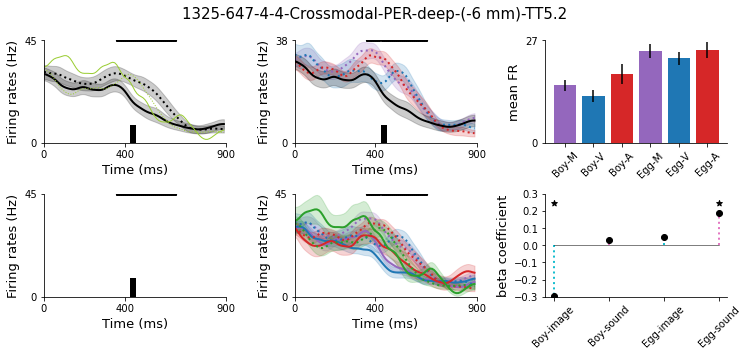

In [9]:
%%time
for cell_run,cell_name in enumerate(cell_list):
    loop_start = time.time()
    # get information about the cell
    cell_info = cell_name.split('-')
    cell_id, rat_id, session_id, region = int(cell_info[0]), cell_info[1], cell_info[2], cell_info[5]
        
    # skip non object-selective cells
    if f[str(cell_id)].attrs['object cell'] == 0:
        continue
        
    # load cell data
    df = pd.read_csv(cell_path/cell_name)
    df.drop(df[df.Correctness==0].index,inplace=True)
    df.reset_index(inplace=True,drop=True)
    df[['Visual','Auditory']] = df[['Visual','Auditory']].fillna('no')
    
    boy_goal = df.loc[df['Visual']=='Boy','RWD_Loc'].values[0]
    boy_aud = df.loc[df['RWD_Loc']==boy_goal,'Auditory'].values[0]
    
    egg_goal = df.loc[df['Visual']=='Egg','RWD_Loc'].values[0]
    egg_aud = df.loc[df['RWD_Loc']==egg_goal,'Auditory'].values[0]  
    
    df['Boy-V'] = (df['Visual'] == 'Boy').astype(int)
    df['Boy-A'] = (df['Auditory'] == boy_aud).astype(int)
    df['Egg-V'] = (df['Visual'] == 'Egg').astype(int)
    df['Egg-A'] = (df['Auditory'] == egg_aud).astype(int)
    
    df['Boy-int'] = df['Boy-V']*df['Boy-A']
    df['Egg-int'] = df['Egg-V']*df['Egg-A']
    
    df['Choice'] = (df['RWD_Loc']==boy_goal).astype(int) 
    
    fr_id = df.columns.get_loc('Var10')  # get the index of the first firing rate column
    fr = df.iloc[:,fr_id:fr_id+90].to_numpy()    # get firing rate data into array
       
    # set independent variables for multiple linear regression
    #x1 = df[['Boy-V','Boy-A','Boy-int','Egg-V','Egg-A','Egg-int']].to_numpy()
    #x2 = df[['Boy-V','Boy-A','Boy-int','Egg-V','Egg-A','Egg-int','Choice']].to_numpy()
    
    x1 = df[['Boy-V','Boy-A','Egg-V','Egg-A']].to_numpy()
    x2 = df[['Boy-V','Boy-A','Egg-V','Egg-A','Choice']].to_numpy()
    
    # load object-selective epoch (time bins)
    object_bin = np.array(f[f'{cell_id}/object_bin'])
    max_bin = f[str(cell_id)].attrs['peak selectivity time']

    # get mean firing rates of object-selective epoch in each trial
    df['Object_mFR'] = df.iloc[:,fr_id+min(object_bin):fr_id+max(object_bin)+1].mean(axis=1)
    fr_id = df.columns.get_loc('Var10')  # get the index of the first firing rate column    
    fr = df['Object_mFR'].to_numpy()

    cond_mFR = [df.groupby(['Type','RWD_Loc']).mean()['Object_mFR']['Multimodal',boy_goal],
                df.groupby(['Type','RWD_Loc']).mean()['Object_mFR']['Visual',boy_goal],
                df.groupby(['Type','RWD_Loc']).mean()['Object_mFR']['Auditory',boy_goal],
                df.groupby(['Type','RWD_Loc']).mean()['Object_mFR']['Multimodal',egg_goal],
                df.groupby(['Type','RWD_Loc']).mean()['Object_mFR']['Visual',egg_goal],
                df.groupby(['Type','RWD_Loc']).mean()['Object_mFR']['Auditory',egg_goal]]  

    cond_sem = [df.groupby(['Type','RWD_Loc']).sem()['Object_mFR']['Multimodal',boy_goal],
                df.groupby(['Type','RWD_Loc']).sem()['Object_mFR']['Visual',boy_goal],
                df.groupby(['Type','RWD_Loc']).sem()['Object_mFR']['Auditory',boy_goal],
                df.groupby(['Type','RWD_Loc']).sem()['Object_mFR']['Multimodal',egg_goal],
                df.groupby(['Type','RWD_Loc']).sem()['Object_mFR']['Visual',egg_goal],
                df.groupby(['Type','RWD_Loc']).sem()['Object_mFR']['Auditory',egg_goal]]                        

    # multiple linear regression
    result = MLR(fr,x1,x2,0)

    beta_coef, beta_coef_choice = result[0], result[1]
    pval, pval_choice = result[2], result[3]
    AIC, AIC_choice = result[4], result[5]
    BIC, BIC_choice = result[6], result[7]

    # multiple linear regression (shuffling)
    shuffle_result = Parallel(n_jobs=-1)(delayed(MLR)(fr,x1,x2,1) for i in range(1000))   
    
    beta_coef_shuffle = np.array([r[0] for r in shuffle_result])
    beta_coef_choice_shuffle = np.array([r[1] for r in shuffle_result])    
    AIC_shuffle = np.array([r[4] for r in shuffle_result])
    AIC_choice_shuffle = np.array([r[5] for r in shuffle_result])      
    BIC_shuffle = np.array([r[6] for r in shuffle_result])
    BIC_choice_shuffle = np.array([r[7] for r in shuffle_result])

    # define response-selective neurons by model improvement after adding response term
    model_improv = AIC-AIC_choice
    if model_improv > np.percentile(AIC_shuffle-AIC_choice_shuffle,99):
        response = 1
    else:
        response = 0

    plot_SDF_beta(df,2,1,1,'both')
    
    # save results into HDF5 format
    save_result(s)
            
    loop_end = time.time()
    loop_time = divmod(loop_end-loop_start,60)
    print(cell_name.strip('.csv'), f'////// {cell_run+1}/{len(cell_list)} completed  //////  {int(loop_time[0])} min {loop_time[1]:.2f} sec')

In [10]:
f.close()
s.close()
print('END')

END
